# 2. Forecasting of real TS (50%)

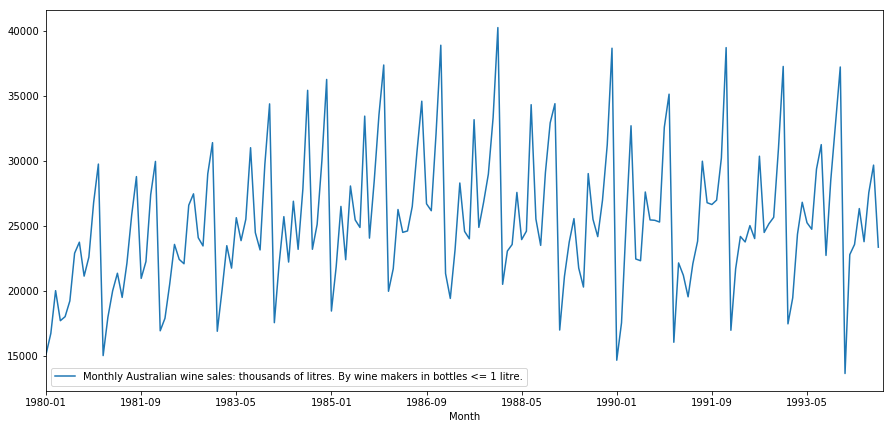

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline

df = pd.read_csv('monthly-australian-wine-sales-th.csv', sep=',', decimal='.', index_col='Month', parse_dates=True, dayfirst=True)
df.plot(figsize=(15,7))

In [80]:
def qualityMACAPE(x,y):
    qlt = (2*(x-y).abs()/(x+y)).replace([np.inf, -np.inf], np.nan)
    return qlt.mean() , (x-y).abs()

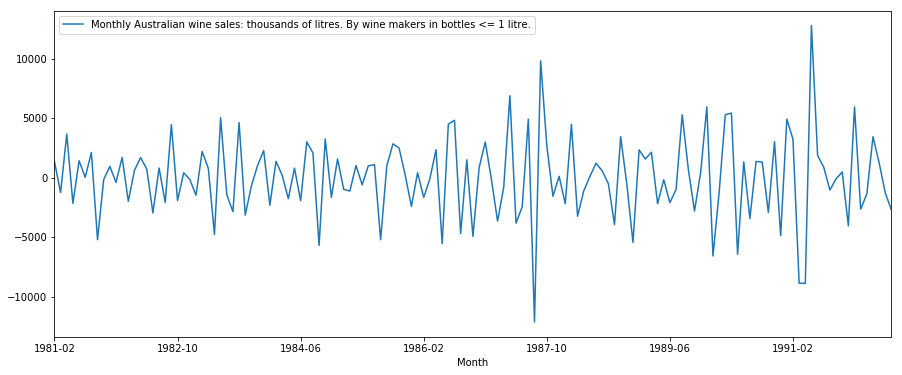

In [81]:
df_cut = df.copy(deep=True)
df_cut = df_cut[:150]

#differencing
p = 12
sdiff_df = (df_cut - df_cut.shift(p))[p:]

diff_df = (sdiff_df  - sdiff_df.shift(1))[1:]
diff_df.plot(figsize=(15,6))

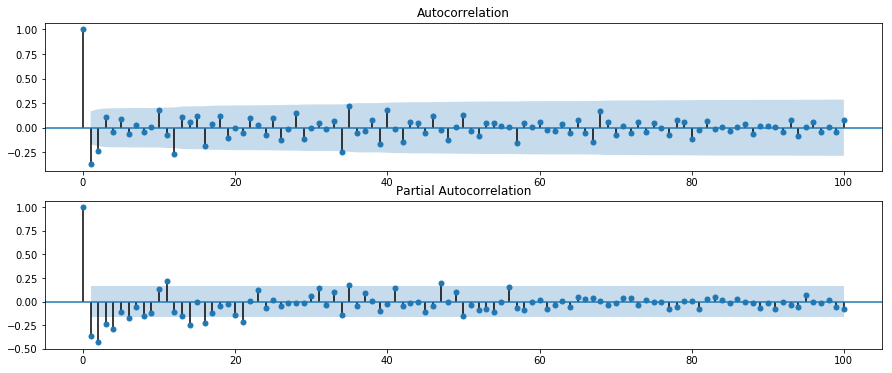

In [82]:
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(diff_df.squeeze(), lags=100, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(diff_df, lags=100, ax=ax2)

I removed the seasonality and trend by differncing. Now the TS is stationary.

In [28]:
import time
def ParamSearch(p,d,q,P,D,Q,s,df):
    aic_value = []
    params = [0]*6
    all_params = []
    start=time.time()
    for pi in p:
        for di in d:
            for qi in q:
                for Pi in P:
                    for Di in D:
                        for Qi in Q:

                            try:
                                mod = sm.tsa.statespace.SARIMAX(df[:'2015-02-01'], trend='n', order=(pi,di,qi), seasonal_order=(Pi,Di,Qi,12)).fit()
                                params[0] = pi
                                params[1] = di
                                params[2] = qi
                                params[3] = Pi
                                params[4] = Di
                                params[5] = Qi
                                aic_value.append(mod.aic)
                                all_params.append(params)
                                break
                            except Exception:
                                pass

    print("\nThe selected parameters are p,d,q,P,D,Q = "+str(all_params[np.argmin(np.array(aic_value))])+"; AIC: "+str(min(aic_value)))
    print("\nTime taken: "+str((time.time()-start)/60.0)+" min")                      
#I know I could have created a grid with lists of parameters, 
#I actually did that but there was some bug and I wasn't able to find it for hours..    
p=[0,1]
d=[0,1]
q=[1,1]
s=12
P=[1,2,3]
D=[0,1]
Q=[0,1]
ParamSearch(p,d,q,P,D,Q,s,diff_df)

C:\Users\Shahane\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Shahane\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Shahane\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Shahane\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



The selected parameters are p,d,q,P,D,Q = [1, 1, 1, 3, 0, 0]; AIC: 2375.36571331

Time taken: 2.016331998507182 min


In [84]:
mod = sm.tsa.statespace.SARIMAX(diff_df, trend='c', order=(1,1,1), seasonal_order=(3,0,0,12)).fit()
print(mod.aic)
print(mod.bic)

C:\Users\Shahane\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2585.0585496
2605.49841608


I found the optimal parameters using gridsearch.

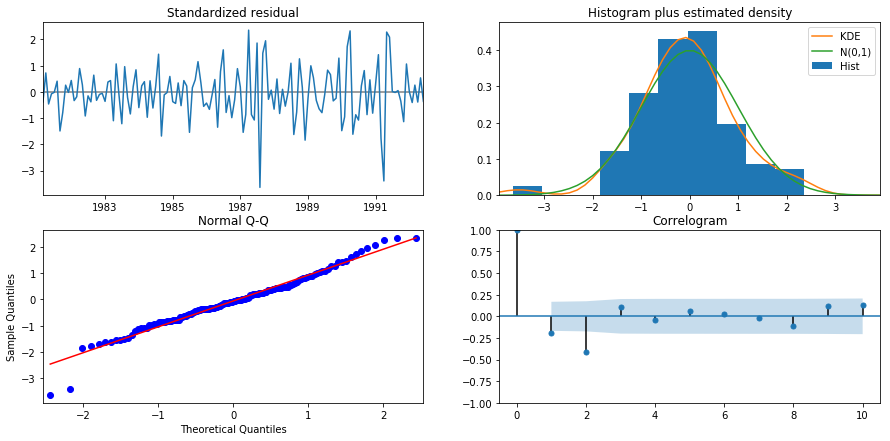

In [85]:
mod.plot_diagnostics(figsize=(15, 7))
plt.show()

In [41]:
p=[0,1]
d=[0,1]
q=[1,1]
s=12
P=[1,2,3]
D=[0,1]
Q=[0,1]
ParamSearch(p,d,q,P,D,Q,s,df[:'1992-06'])

C:\Users\Shahane\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Shahane\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



The selected parameters are p,d,q,P,D,Q = [1, 1, 1, 3, 1, 0]; AIC: 2572.43178901

Time taken: 1.105996588865916 min


In [86]:
mod = sm.tsa.statespace.SARIMAX(df[:'1992-06'], order=(1,1,1), seasonal_order=(3,1,0,12)).fit()

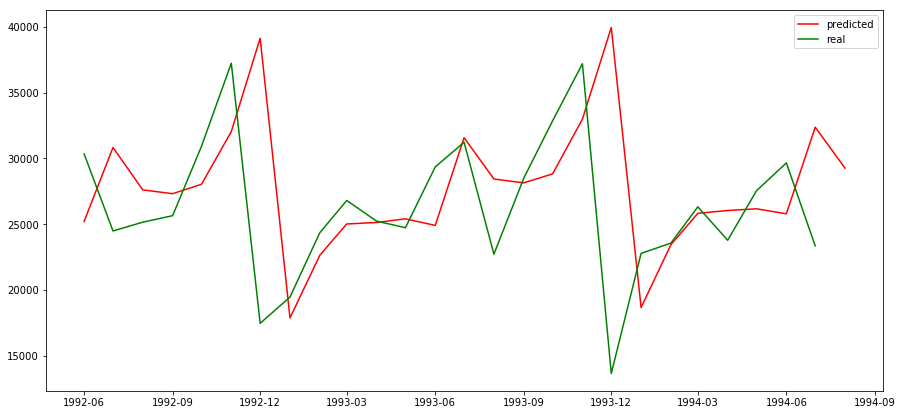

In [87]:
predict=mod.predict(start='1992-06', end='1994-08')
plt.figure(figsize=(15,7))
plt.plot(predict.index,predict,color='r',label = 'predicted')
plt.plot(predict.index,np.array(df['1992-07':]),color='g', label = 'real')
plt.legend()
plt.show()



In [101]:
acc = 1-qualityMACAPE(predict,df['Monthly Australian wine sales: thousands of litres. By wine makers in bottles <= 1 litre.']['1992-07':].values)[0]
print(acc)

0.8341326663130656
